# Modelo MLP para Previsão de Preços de Criptomoedas

## Importação das Bibliotecas

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import joblib

## PASSO 1: Carregar e Preparar os Dados

**Objetivo:** Ler o arquivo CSV e garantir que ele esteja em ordem.

In [44]:
# Carrega os dados do arquivo CSV
df = pd.read_csv(r"C:\Users\david\Desktop\trading-algoritmico\data\fechamentos\SOLUSDT_15m_data.csv")

# Garante que a coluna 'timestamp' seja do tipo data e ordena os dados
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values('timestamp')
df = df.reset_index(drop=True)

# Remove colunas com nomes "Unnamed".
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

print(f"Dados carregados: {df.shape[0]} registros.")
print(df.head())

Dados carregados: 70080 registros.
            timestamp   open   high    low  close     volume
0 2023-07-20 15:30:00  26.20  26.21  25.75  25.91  121467.56
1 2023-07-20 15:45:00  25.90  25.91  25.57  25.69  191787.08
2 2023-07-20 16:00:00  25.69  25.77  25.56  25.66  106474.05
3 2023-07-20 16:15:00  25.67  25.67  25.21  25.37  170476.73
4 2023-07-20 16:30:00  25.38  25.47  25.33  25.42   75885.50


## PASSO 2: Preparar os Dados para o Modelo

**Objetivo:** Transformar os dados brutos em um formato que a rede neural entenda (features e target).

In [45]:
# --- Calculo dos Indicadores ---
# Calcula o Retorno Percentual
df['close_pct'] = df['close'].pct_change()
df['volume_pct'] = df['volume'].pct_change()

In [ ]:
# --- Definição das Variáveis ---
FEATURE_COLUMNS = ['open', 'high', 'low', 'close', 'volume', 'close_pct', 'volume_pct']
TARGET_COLUMN = 'close'

# SEQUENCE_LENGTH: Quantos períodos olharemos para trás para prever o próximo.
# Por exemplo, com 24, usaremos os dados das últimas 24 horas para fazer uma previsão.
SEQUENCE_LENGTH = 24

# --- Criação das Features (X) e do Alvo (y) ---
# O alvo (y) será binário: 1 se o preço subir, 0 se não.
# df[TARGET_COLUMN].shift(-1) pega o preço de fechamento do *próximo* período.
y = (df[TARGET_COLUMN].shift(-1) > df[TARGET_COLUMN]).astype(int)

# As features (X) serão os dados OHLCV.
X_raw = df[FEATURE_COLUMNS]

print(f"Features definidas: {FEATURE_COLUMNS}")
print(f"Sequence length: {SEQUENCE_LENGTH}")
print(f"Shape dos dados brutos: {X_raw.shape}")

Features definidas: ['open', 'high', 'low', 'close', 'volume', 'close_pct', 'volume_pct']
Sequence length: 24
Shape dos dados brutos: (70080, 7)


In [47]:
# --- Normalização dos Dados ---
# Importante para redes neurais, pois ajuda na convergência do modelo
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_raw)

print(f"Dados normalizados. Shape: {X_scaled.shape}")
print(f"Min: {X_scaled.min()}, Max: {X_scaled.max()}")

Dados normalizados. Shape: (70080, 7)
Min: nan, Max: nan


In [48]:
# --- Criação das Sequências ---
# Cria sequências de dados para o modelo
X_sequences, y_sequences = [], []
for i in range(len(X_scaled) - SEQUENCE_LENGTH):
    X_sequences.append(X_scaled[i : i + SEQUENCE_LENGTH])
    y_sequences.append(y[i + SEQUENCE_LENGTH -1]) # O alvo corresponde ao final da sequência

X = np.array(X_sequences)
y = np.array(y_sequences)

print(f"Sequências criadas. X shape: {X.shape}, y shape: {y.shape}")

Sequências criadas. X shape: (70056, 24, 7), y shape: (70056,)


In [49]:
# --- Reshape do X para o MLP ---
# O MLP espera uma entrada 2D, então precisa achatar as sequências
num_samples = X.shape[0]
num_features_flat = X.shape[1] * X.shape[2]
X = X.reshape(num_samples, num_features_flat)

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (alvo): {y.shape}")

Shape de X (features): (70056, 168)
Shape de y (alvo): (70056,)


In [ ]:
# --- Divisão em Treino e Teste ---
# Divisão dos dados em treino e teste
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

# Tentativa de balancear as classes, evitando a mesma reposta sempre
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weight_dict = dict(enumerate(class_weights))

print(f"Amostras de treino: {len(X_train)}")
print(f"Amostras de teste: {len(X_test)}")
print(f"Distribuição do target no treino: {np.bincount(y_train)}")
print(f"Distribuição do target no teste: {np.bincount(y_test)}")

Amostras de treino: 56044
Amostras de teste: 14012
Distribuição do target no treino: [28324 27720]
Distribuição do target no teste: [7019 6993]


## PASSO 3: Construir o Modelo (MLP)

**Objetivo:** Definir a arquitetura da nossa rede neural.

In [51]:
model = Sequential()

# Camada de Entrada: Define o formato da nossa entrada
model.add(Input(shape=(num_features_flat,)))

# 1ª Camada Oculta: Primeira camada que aprende os padrões
model.add(Dense(units=64, activation='relu'))

# Camada de Dropout: Ajuda a prevenir overfitting
model.add(Dropout(rate=0.2))

# 2ª Camada Oculta: Segunda camada para aprender padrões mais complexos
model.add(Dense(units=32, activation='relu'))

# Camada de Saída: Gera a previsão final
model.add(Dense(units=1, activation='sigmoid'))

In [52]:
# --- Compilação do Modelo ---
# O modelo é compilado com o otimizador Adam e a função de perda binary_crossentropy, adequada para problemas de classificação binária
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Mostra um resumo da arquitetura do modelo
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │        10,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

## PASSO 4: Treinar o Modelo

**Objetivo:** Alimentar o modelo com os dados de treino para que ele aprenda.

In [53]:
history = model.fit(
    X_train,
    y_train,
    epochs=30,  # epochs: Quantas vezes o modelo verá todo o conjunto de dados de treino.
    batch_size=32,  # batch_size: Quantas amostras o modelo vê antes de atualizar seus pesos.
    validation_data=(X_test, y_test),  # Dados para validar o modelo a cada época.
    verbose=1 # Mostra uma barra de progresso.
)

Epoch 1/30
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5045 - loss: 0.6952 - val_accuracy: 0.5009 - val_loss: 0.6933
Epoch 2/30
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5059 - loss: 0.6931 - val_accuracy: 0.5009 - val_loss: 0.6932
Epoch 3/30
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5054 - loss: 0.6931 - val_accuracy: 0.5009 - val_loss: 0.6932
Epoch 4/30
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5048 - loss: 0.6931 - val_accuracy: 0.5009 - val_loss: 0.6933
Epoch 5/30
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5063 - loss: 0.6931 - val_accuracy: 0.5009 - val_loss: 0.6932
Epoch 6/30
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5056 - loss: 0.6931 - val_accuracy: 0.5009 - val_loss: 0.6932
Epoch 7/30
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5057 - loss: 0.6931 - val_accuracy: 0.5009 - val_loss: 0.6932
Epoch 8/30
1752/1752 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5071 - loss: 0.6931 - 

## PASSO 5: Avaliar o Modelo

**Objetivo:** Verificar o quão bem o modelo se saiu nos dados de teste.

In [54]:
print("\n--- PASSO 5: Avaliando o Modelo ---")

# Fazer previsões nos dados de teste. A saída será uma probabilidade
probabilities = model.predict(X_test)

# Converter probabilidades em classes (0 ou 1) usando um limiar de 0.5
predictions = (probabilities > 0.5).astype(int)

# Calcular e mostrar as métricas
accuracy = accuracy_score(y_test, predictions)
cm = confusion_matrix(y_test, predictions)
report = classification_report(y_test, predictions, target_names=['Não Sobe', 'Sobe'])

print(f"Acurácia no Teste: {accuracy * 100:.2f}%")
print("\nRelatório de Classificação:")
print(report)


--- PASSO 5: Avaliando o Modelo ---
438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step
Acurácia no Teste: 50.09%

Relatório de Classificação:
              precision    recall  f1-score   support

    Não Sobe       0.50      1.00      0.67      7019
        Sobe       0.00      0.00      0.00      6993

    accuracy                           0.50     14012
   macro avg       0.25      0.50      0.33     14012
weighted avg       0.25      0.50      0.33     14012



C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\david\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capital


Matriz de Confusão:


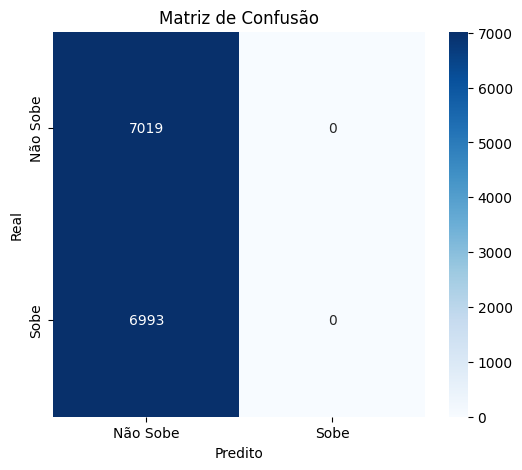

In [55]:
print("\nMatriz de Confusão:")
# Um mapa de calor para visualizar a matriz de confusão
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Não Sobe', 'Sobe'], yticklabels=['Não Sobe', 'Sobe'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

## PASSO 6: Visualizar o Treinamento

**Objetivo:** Plotar gráficos para ver se o modelo aprendeu bem ou se teve overfitting.

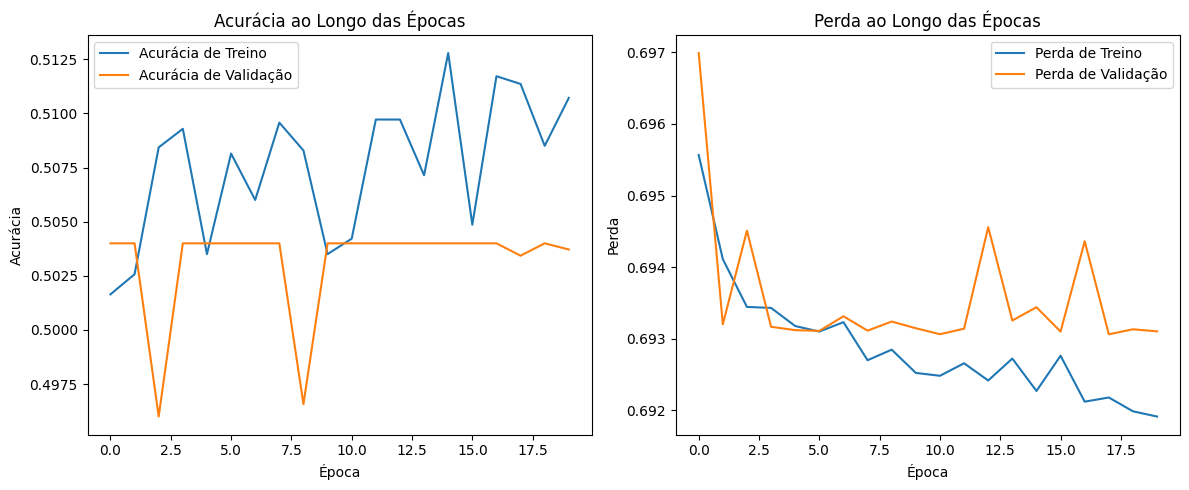

In [16]:
plt.figure(figsize=(12, 5))

# Gráfico da Acurácia
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Acurácia de Treino')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Acurácia ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()

# Gráfico da Perda (Loss)
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Perda ao Longo das Épocas')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.legend()

plt.tight_layout()
plt.show()

## PASSO 7: Salvar o Modelo

**Objetivo:** Salvar o modelo treinado e o normalizador para uso futuro.

In [ ]:
# Por enquanto não é necessário salvar o modelo
MODEL_PATH = "mlp_basic_model.h5"
SCALER_PATH = "basic_scaler.pkl"

model.save(MODEL_PATH)
joblib.dump(scaler, SCALER_PATH)

print(f"Modelo salvo em: {MODEL_PATH}")
print(f"Normalizador salvo em: {SCALER_PATH}")

## Conclusão

### Já integrado:

1. **Carrega dados históricos**
2. **Prepara os dados**
3. **Constrói um MLP**
4. **Treina o modelo**
5. **Avalia o desempenho**
6. **Visualiza o treinamento**
7. **Salva o modelo**

### Próximos Passos:
- ENTENDER POR QUE O MODELO SÓ FALA QUE VAI SUBIR
- Adicionar features técnicas, prepara-las e dar ao treino do modelo
- Implementar validação cruzada temporal
- Testar diferentes janelas temporais